In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from scipy.special import binom
from IPython.display import display, HTML

In [2]:
# Inline all plots to cell outputs
%matplotlib inline

In [3]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
    plt.legend(title='RG')
    plt.show() #change ticks to integers only

def plot_matrix(matrix, title='Matrix', vmax=None):
    n, m = matrix.shape
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
    plt.colorbar()
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(m)+0.5)
    ax.set_xticklabels(np.arange(n))
    ax.set_yticklabels(np.arange(m))
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

Bradscratch stuff below here

In [4]:
# Brad functions
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def is_greater_than(x, threshold):
    return 1 if x > threshold else 0

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def make_truth_matrix(n_groups, libraries):
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i==j:
                truth[i,j] = -1
            elif libraries[i] == libraries[j] and i !=j:
                truth[i,j] = 1
    return truth

def package_and_sort(raw_distances, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
    return pd.DataFrame(zero_diag(raw_distances), index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)


In [5]:
# Just splitting this off to cache the values
print "Reading inputs"
meta = read_metadata('test_2_libraries.tabledata.json.read_groups.json')
table = read_table('test2libs.tabledata.json')  

# meta = read_metadata('test_10_libraries.read_groups.json')
# table = read_table('test_10_libraries.table.json')  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)

print "Getting the truth"
truth = make_truth_matrix(n_groups, libraries)

print "Calculating pairwise distances"
ap_affinity = package_and_sort(all_pairs_affinity(table, n_groups), groups, libraries)

Reading inputs
Getting the truth
Calculating pairwise distances


In [6]:
# Evaluation function + utilities
def summarize_result(result, truth):
    all_positives = result[truth > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[truth == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    labels = ["p(same-library | truly same-library)", "p(different-library | truly different-library)", "Rand index"]
    return pd.DataFrame([true_positive_rate, true_negative_rate, rand_index], index=labels, columns=["Value"])

def plot_distance_histogram(distances, truth):
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    my_bins=np.arange(-0.01,1,.01)
    plt.hist(same_distances, bins=my_bins, alpha=0.5, label='Same-library')
    plt.hist(diff_distances, bins=my_bins, alpha=0.5, label='Different-library')
    plt.legend(loc='upper right')
    plt.title('Distribution of Pairwise Distances')
    plt.show()
    
apply_threshold = np.vectorize(is_greater_than)

# Primary evaluatio
def evaluate(distances, truth, threshold):
    result = apply_threshold(distances, threshold)
    display(HTML('<h3>Evaluation Metrics</h3>'))
    display(summarize_result(result, truth))
    plot_matrix(distances, title='Pairwise Distance Values')
    plot_distance_histogram(distances, truth)

In [7]:
# threshold getter functions

# TODO - what if min <= max????
def min_minus_max(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

# Generic outer function
def get_threshold(distances, truth, threshold_func):
    return threshold_func(distances, truth)

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


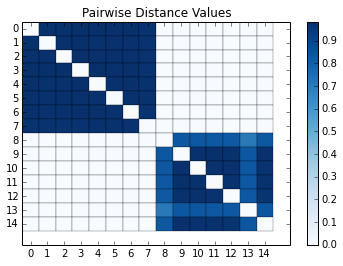

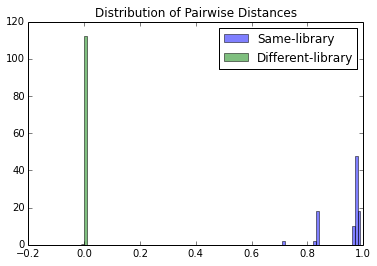

get_threshold


In [9]:
# Perform the experiment
def run_experiment(distances, truth, threshold_getter, combiner, evaluate_subsets):
#     TODO
#     split into 5 partitions
#     thresholds = []
#     for each partition
#         d1 = subset distances for readgroups outside partition
#         d2 = subset distances for readgroups inside partition
#         t = get_threshold(d1)
#         thresholds.append(t)
#         if evaluate_subsets: evaluate(d2)
#     combined_threshold = combiner(thresholds)
#     evaluate(distances, truth, combined_threshold)

    threshold = get_threshold(distances, truth, threshold_getter)
    evaluate(distances, truth, threshold)

    
run_experiment(ap_affinity, truth, min_minus_max, np.mean, True)    
print get_threshold.__name__